In [19]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from transformers import pipeline
import re
import unidecode
import jellyfish
from Levenshtein import distance as levenshtein_distance

In [20]:

df = pd.read_excel("AML-stageIA.xlsx")
df.columns = df.columns.str.strip()
df.head()

,Full Name,Age / DOB,Nationality,Risk Category,Passport Number,Country of Residence,Source of Funds,Risk Score,Watchlist Flag,Notes
0,Carlos Mendoza,45,Mexico,PEP,MXP1234567,Panama,Real Estate,82,Yes,Former governor
1,فاطمة الحربي,1982-07-14,Saudi Arabia,Money Laundering,SA987654321,UAE,Unknown,91,Yes,Linked to shell companies
2,Jean Dupont,61,France,Terrorism Financing,FR112233445,Syria,Donations,88,Yes,Under EU sanctions
3,Amina Yusuf,38,Nigeria,PEP,NG556677889,UK,Government Salary,67,No,Member of parliament
4,Igor Petrov,1975-03-22,Russia,Money Laundering,RU998877665,Cyprus,Offshore Funds,79,Yes,Offshore accounts in Cyprus


In [21]:
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-ar-fr")

def is_arabic(text):
    return any('\u0600' <= c <= '\u06FF' for c in text)
def translate_if_arabic(name):
    if is_arabic(name):
        try:
            result = translator(name, max_length=40)[0]['translation_text']
            return result
        except:
            return name
    return name


C:\Users\achraf\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\achraf\AppData\Roaming\Python\Python311\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [22]:
def clean_name(name):
    name = str(name).strip()  
    name = re.sub(r'[^\w\s]', '', name) 
    name = unidecode.unidecode(name)    
    name = name.upper()                
    return name


In [23]:
def translate_and_clean(name):
    translated = translate_if_arabic(name)
    return clean_name(translated)

df["Cleaned Name"] = df["Full Name"].apply(translate_and_clean)


In [24]:
print(df['Risk Category'].value_counts())
print(df['Nationality'].value_counts().head(10))
print(df.describe())

Risk Category
PEP                    68
Money Laundering       68
Terrorism Financing    49
Name: count, dtype: int64
Nationality
Saudi Arabia    19
Russia          12
Jordan          11
Egypt           10
Kuwait          10
Nigeria          9
Iraq             9
China            8
France           7
UAE              7
Name: count, dtype: int64
       Risk Score
count  185.000000
mean    71.064865
std     11.309678
min     52.000000
25%     61.000000
50%     69.000000
75%     84.000000
max     91.000000


In [25]:
print("Après nettoyage :")
df[['Full Name', 'Cleaned Name']].head(10)


Après nettoyage :


,Full Name,Cleaned Name
0,Carlos Mendoza,CARLOS MENDOZA
1,فاطمة الحربي,FATIMA ALGHARBI
2,Jean Dupont,JEAN DUPONT
3,Amina Yusuf,AMINA YUSUF
4,Igor Petrov,IGOR PETROV
5,محمد عبد الله,MOHAMMED ABDALLAH
6,Lina Chen,LINA CHEN
7,David Stein,DAVID STEIN
8,Sofia Romero,SOFIA ROMERO
9,يوسف الكيلاني,YOUSEF KILANI


In [26]:
print("Doublons détectés :", df.duplicated(subset='Cleaned Name').sum())


Doublons détectés : 1


In [27]:

def phonetic_simplify(name):
    name = name.lower()
    name = re.sub(r'(.)\1+', r'\1', name)  #  yuuusssef → yusef
    name = re.sub(r'[aeiouy]', '', name)   # enlève voyelles pour homogénéité
    name = re.sub(r'[^a-z]', '', name)     # enlève tout sauf lettres
    return name


In [28]:
def compare_names(input_name, df, top_n=2):
    input_clean = translate_and_clean(input_name)
    print(f"Traduction utilisée pour la comparaison : {input_clean}")

    input_sdx = jellyfish.soundex(input_clean)
    input_phonetic = phonetic_simplify(input_clean)

    input_raw = clean_name(input_name)
    input_raw_sdx = jellyfish.soundex(input_raw)
    input_raw_phonetic = phonetic_simplify(input_raw)

    results = []
    for _, row in df.iterrows():
        db_names = [row.get("Cleaned Name", ""), row.get("Translittéré", "")]
        best_score = 0

        for db_name in db_names:
            if not db_name:
                continue
            db_sdx = jellyfish.soundex(db_name)
            db_phonetic = phonetic_simplify(db_name)

            sdx_score = 100 if input_sdx == db_sdx else 0
            lev_dist = levenshtein_distance(input_phonetic, db_phonetic)
            lev_score = max(0, 100 - lev_dist * 3)
            final_score = round((sdx_score + lev_score) / 2)

            sdx_score_raw = 100 if input_raw_sdx == db_sdx else 0
            lev_dist_raw = levenshtein_distance(input_raw_phonetic, db_phonetic)
            lev_score_raw = max(0, 100 - lev_dist_raw * 3)
            final_score_raw = round((sdx_score_raw + lev_score_raw) / 2)

            score = max(final_score, final_score_raw)
            best_score = max(best_score, score)

        results.append((row["Full Name"], best_score, row["Risk Category"]))

    results.sort(key=lambda x: x[1], reverse=True)
    return results[:top_n]

In [29]:
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    if len(s2) == 0:
        return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

In [30]:


def soundex_match(a, b):
    return int(a[0] == b[0]) if a and b else 0


In [31]:
def extract_features_ml(input_name, row):
    input_clean = clean_name(input_name)
    db_name = clean_name(row['Cleaned Name'])
    lev_dist = levenshtein_distance(input_clean, db_name)
    lev_score = max(0, 100 - lev_dist * 3)
    sdx_match = soundex_match(input_clean, db_name)
    is_high_risk = int(row['Risk Score'] >= 85)
    is_medium_risk = int(70 <= row['Risk Score'] < 85)
    has_nationality_match = int(row['Nationality'] == 'Tunisia')
    return [lev_score, sdx_match, is_high_risk, is_medium_risk, has_nationality_match]

In [32]:
# Génération du dataset  
X_ml, y_ml = [], []
for _, row in df.iterrows():
  
    X_ml.append(extract_features_ml(row['Full Name'], row))
    y_ml.append("Blocked")
    fake_name = ''.join(np.random.choice(list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"), max(3, len(row['Full Name']))))
    X_ml.append(extract_features_ml(fake_name, row))
    y_ml.append("Allowed") 
X_ml = np.array(X_ml)
le_ml = LabelEncoder()
y_ml_encoded = le_ml.fit_transform(y_ml)


In [33]:
# Entrainement 
from sklearn.metrics import f1_score

X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml, y_ml_encoded, test_size=0.2, stratify=y_ml_encoded)
models_ml = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}
results_ml = {}

for name, model in models_ml.items():
    model.fit(X_train_ml, y_train_ml)
    y_pred = model.predict(X_test_ml)
    y_score = model.predict_proba(X_test_ml)
    results_ml[name] = {
        "model": model,
        "accuracy": accuracy_score(y_test_ml, y_pred),
        "recall": recall_score(y_test_ml, y_pred, average='macro'),
        "confusion_matrix": confusion_matrix(y_test_ml, y_pred),
        "report": classification_report(y_test_ml, y_pred, target_names=le_ml.classes_),
        "f1": f1_score(y_test_ml, y_pred, average='macro'),
    }

C:\Users\achraf\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [10:39:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\achraf\AppData\Local\Temp\ipykernel_2180\144352256.py:17: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\achraf\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


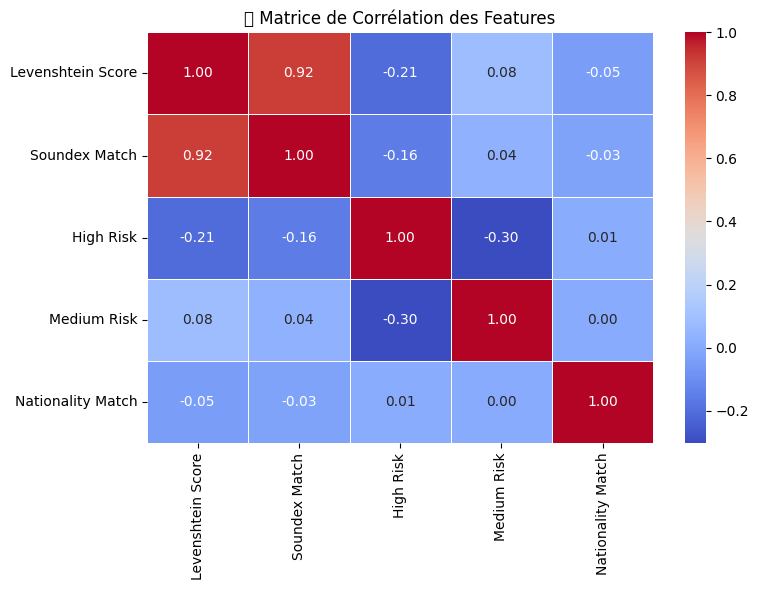

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

X_df = pd.DataFrame(X_ml, columns=[
    "Levenshtein Score", 
    "Soundex Match", 
    "High Risk", 
    "Medium Risk", 
    "Nationality Match"
])

corr_matrix = X_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("🔍 Matrice de Corrélation des Features")
plt.tight_layout()
plt.show()



In [35]:
input_name = input("🔎 Entrez un nom (arabe ou français) : ")
matches = compare_names(input_name, df)
SEUIL = 50
if not matches or max(score for _, score, _ in matches) < SEUIL:
    print("\nAucun nom similaire trouvé dans la base. Prédiction ML :")
    best_row = df.iloc[0]  
    features = np.array(extract_features_ml(input_name, best_row)).reshape(1, -1)
    decisions = []
    for name, model in models_ml.items():
        proba = model.predict_proba(features)[0]
        classes = le_ml.inverse_transform(np.arange(len(proba)))
        print(f"\n--- {name} ---")
        for c, p in zip(classes, proba):
            print(f"{c}: {p:.2f}")
        decision = classes[np.argmax(proba)]
        decisions.append(decision)
        print(f"Décision recommandée : {decision}")
        print(f"Accuracy: {results_ml[name]['accuracy']:.2f} | F1: {results_ml[name]['f1']:.2f}")
    print("\n Décision finale : Allowed (la personne n'existe pas dans la liste AML)")
else:
    print("\n=== Résultats les plus proches ===")
    for name, score, risk in matches:
        if score >= SEUIL:
            print(f" Nom : {name} |  Score : {score}/100 |  Risque : {risk}")
            print("Décision : Blocked")

Traduction utilisée pour la comparaison : 

Aucun nom similaire trouvé dans la base. Prédiction ML :

--- Random Forest ---
Allowed: 1.00
Blocked: 0.00
Décision recommandée : Allowed
Accuracy: 0.99 | F1: 0.99

--- Logistic Regression ---
Allowed: 1.00
Blocked: 0.00
Décision recommandée : Allowed
Accuracy: 0.96 | F1: 0.96

--- XGBoost ---
Allowed: 1.00
Blocked: 0.00
Décision recommandée : Allowed
Accuracy: 0.97 | F1: 0.97

 Décision finale : Allowed (la personne n'existe pas dans la liste AML)
